<a href="https://colab.research.google.com/github/taareek/semantic_segmentation/blob/main/FCN_8_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this notebook, I have implemented Fully Connected Network for semantic segementation. You can find this paper [in this link](https://arxiv.org/abs/1411.4038). I have used pytorch to implement this model and it is implemented from scratcch. VGG-16 has been used as backbone in this code, and encoder-decoder architechture adopted to implement FCN-32, FCN-16, FCN-8 respectively. For better undestanding, I will write this code as encoder and decoder architecture which will give you the whole idea behind this model, and I will also write three different class for FCN-32, FCN-16 and FCN-8 that can be used as separate model. 

**Importing necessary libraies**

In [ ]:
import torch
import torch.nn as nn
from torchvision import models 
from torchvision.models.vgg import VGG

In [ ]:
# taking vgg-16 model as model 
model = models.vgg16()
# print vgg-16 model
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Here we can see that, vgg-16 has two parts, one is convolution and another one is classifier that is based on fc layer (fully connected layer). Convolution is basically used for extract meaningful features from input image, and classifier used to produce class probability for that input image. In segmentation, we would like to generate a segmented mask for input image. That's why, we will discard classifier and use only convolution layers to extract feature maps from image. And this is what an encoders does, extract feature from image. Now we will build an encoder from vgg-16 model. We will consider three aspects to implent fully connected network for semantic segmentation. 

1.   Replace fully connected layers with 1 x 1 convolution layer. Basically, it will remove dense layer and produce output as 7 x 7 x 512. We will have 512 feature maps with a shape of 7 x 7.
2.   Up sampling through the transposed convolutional layer. It will up sample our feature maps with given stride size. For example, if we apply transposed convolution in 7x7 image with stride size of 2, it will produce an image with shape 14 x 14. Sometimes this process is also called deconvolution but in semantic segmentation, it's bad practice to adress as deconvolution. 
3.   Skip connection. This allows the network to use information from multiple resolution scales. By this proces, we will generate our FCN-8, FCN-16, and FCN-32 model. Basically, it takes feature maps from self pooling layer as well as previous then combine both of them to produce final output. 
A visual representation of transposed convolution and skip connection is given below: 
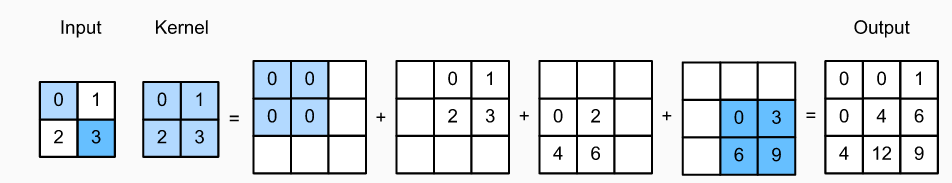

Figure: transposed convolution



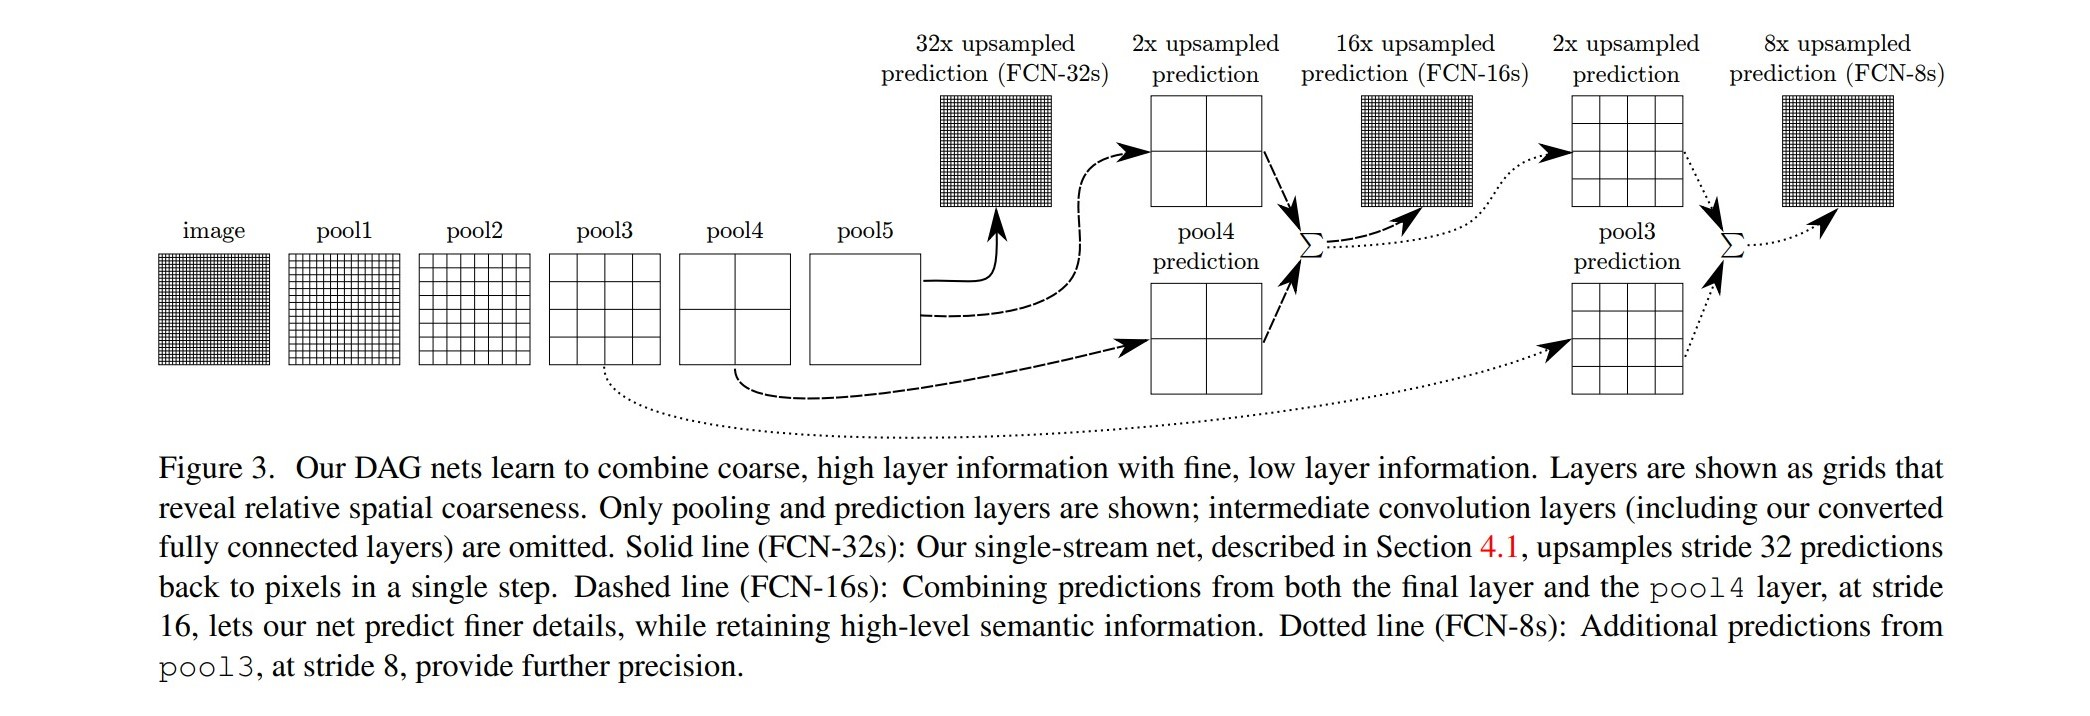

# Encoder

In [ ]:
class Encoder(VGG):
  def __init__(self, pre_trained= True, requires_grad= True, batch_norm= False, show_params= False):
    super().__init__(self.make_layers(batch_norm))

    # taking pre-trained vgg-16
    if pre_trained:
      exec("self.load_state_dict(models.vgg16(pretrained= True).state_dict())")
    
    # if you'd like to freeze the convolution layers (encoder) then requires_grad should be False. And you can avoid training  
    if not requires_grad:
      for parameter in super().parameters():
        parameter.requires_grad = False

    # removing classifier (fc layer)
    del self.classifier

    # if you want to display the parametes 
    if show_params:
      for name, parameter in self.named_parameters():
        print(name, parameter.size())

  # function to make layers
  def make_layers(self, batch_norm):
    # cfg contains the information of output depth as well as Maxpoolilng 
    cfg = [64, 64, 'M',
	        128, 128, 'M', 
	        256, 256, 256, 'M', 
	        512, 512, 512, 'M', 
	        512, 512, 512, 'M']
    layers = []
    in_channels = 3

    for v in cfg:
      if v == 'M':
        layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
      else:
        conv2d = nn.Conv2d(in_channels, v, kernel_size= 3, padding= 1)
        if batch_norm:
          layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace= True)]
        else:
          layers += [conv2d, nn.ReLU(inplace=True)]       
        in_channels = v
    return nn.Sequential(*layers)

  def forward(self, x):
    # making ranges for each maxpooling layer to perform skip connection 
    ranges = ((0,5), (5, 10), (10, 17), (17, 24), (24, 31))
    output = {}
    for idx in range(len(ranges)):
      for layer in range(ranges[idx][0], ranges[idx][1]):
        x = self.features[layer](x)
      output["pool%d"%(idx+1)] = x
    return output 


Here, we have defined our encoder. We used pre-trained weights for convolutional layers. We write this in a way that user has proper authority to option to use pre-trained weights, batch normalization, requires grad or not. Below is the architechture of our encoder. This encoder will provide us feature maps from our input image that has been passed through entire convolution. The goal of encoder is to extract features from image.

In [ ]:
a = Encoder()
print(a)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Encoder(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [ ]:
model = Encoder(show_params= True)

features.0.weight torch.Size([64, 3, 3, 3])
features.0.bias torch.Size([64])
features.2.weight torch.Size([64, 64, 3, 3])
features.2.bias torch.Size([64])
features.5.weight torch.Size([128, 64, 3, 3])
features.5.bias torch.Size([128])
features.7.weight torch.Size([128, 128, 3, 3])
features.7.bias torch.Size([128])
features.10.weight torch.Size([256, 128, 3, 3])
features.10.bias torch.Size([256])
features.12.weight torch.Size([256, 256, 3, 3])
features.12.bias torch.Size([256])
features.14.weight torch.Size([256, 256, 3, 3])
features.14.bias torch.Size([256])
features.17.weight torch.Size([512, 256, 3, 3])
features.17.bias torch.Size([512])
features.19.weight torch.Size([512, 512, 3, 3])
features.19.bias torch.Size([512])
features.21.weight torch.Size([512, 512, 3, 3])
features.21.bias torch.Size([512])
features.24.weight torch.Size([512, 512, 3, 3])
features.24.bias torch.Size([512])
features.26.weight torch.Size([512, 512, 3, 3])
features.26.bias torch.Size([512])
features.28.weight t

# Decoder

The goal of decoder is to upscale the feature maps using transposed convolution. And by this proces, we will get the same size as original image.

In [ ]:
class Decoder(nn.Module):
  def __init__(self, encoder, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.encoder = encoder

    # performing transposed convolution to upsample all maxpooling layers
    self.relu = nn.ReLU(inplace= True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding= 1, output_padding= 1, dilation= 1) # 1 x 1 convolution
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score. layer (replace the FC layers), this will return our segmented image as output.
    self.score = nn.Conv2d(32, n_classes, 1)

  def forward(self, x):
    x = self.encoder(x)
    # performing skip connection [it will connect the output of one layer to a non-adjacent layer]
    pool_5 = x['pool5'] # output of vgg16 
    pool_4 = x['pool4']
    pool_3 = x['pool3']

    # making FCN-8
    print(f"Input shape of decoder: {pool_5.shape}")
    x = self.relu(self.deconv1(pool_5))
    print("After deconv 1: ",x.shape)

    x = self.bn1(x + pool_4) # fcn-16, adding output layer with previous layer
    print(f"After adding pool_4 and pool_5: {x.shape}")
    x = self.relu(self.deconv2(x)) # deconv. weighted output
    print(f"After deconv 2: {x.shape}")

    x = self.bn2(x + pool_3) # fcn-8 
    print(f"After adding pool_3 and pool_4+ pool_5: {x.shape}")
    x = self.bn3(self.relu(self.deconv3(x)))
    print(f"After deconv 3: {x.shape}")

    x = self.bn4(self.relu(self.deconv4(x)))
    print(f"After deconv 4: {x.shape}")

    x = self.bn5(self.relu(self.deconv5(x)))
    print(f"After deconv 5: {x.shape}")
    
    x = self.score(x)

    return x

In [ ]:
# demo
n_classes = 6
batch_size = 12
# It accepts any image size multiple of 32.
img_width = 256
img_height = 256

fcn_8 = Decoder(Encoder(), n_classes)
output = fcn_8(torch.randn([batch_size, 3, img_width, img_height]))
print(f"Output shape: {output.shape}") # [10, 12, 512, 512]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Input shape of decoder: torch.Size([12, 512, 8, 8])
After deconv 1:  torch.Size([12, 512, 16, 16])
After adding pool_4 and pool_5: torch.Size([12, 512, 16, 16])
After deconv 2: torch.Size([12, 256, 32, 32])
After adding pool_3 and pool_4+ pool_5: torch.Size([12, 256, 32, 32])
After deconv 3: torch.Size([12, 128, 64, 64])
After deconv 4: torch.Size([12, 64, 128, 128])
After deconv 5: torch.Size([12, 32, 256, 256])
torch.Size([12, 6, 256, 256])


# FCN-32

In [ ]:
class FCN_32(nn.Module):
  def __init__(self, encoder, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.encoder = encoder

    # performing transposed convolution to upsample all maxpooling layers
    self.relu = nn.ReLU(inplace= True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding= 1, output_padding= 1, dilation= 1) # 1 x 1 convolution
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score. layer (replace the FC layers), this will return our segmented image as output.
    self.score = nn.Conv2d(32, n_classes, 1)

  def forward(self, x):
    x = self.encoder(x)
    # performing skip connection [it will connect the output of one layer to a non-adjacent layer]
    pool_5 = x['pool5'] # output of vgg16 

    # making FCN-32
    x = self.relu(self.deconv1(pool_5))
    x = self.bn1(x)
    x = self.bn2(self.relu(self.deconv2(x))) 
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x)

    return x

In [ ]:
# demo
n_classes = 6
batch_size = 8
# It accepts any image size multiple of 32.
img_width = 256
img_height = 256

fcn_32 = FCN_32(Encoder(), n_classes)
output = fcn_32(torch.randn([batch_size, 3, img_width, img_height]))
print(f"Output shape: {output.shape}") # [8, 6, 256, 256]

Output shape: torch.Size([8, 6, 256, 256])


# FCN-16

In [ ]:
class FCN_16(nn.Module):
  def __init__(self, encoder, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.encoder = encoder

    # performing transposed convolution to upsample all maxpooling layers
    self.relu = nn.ReLU(inplace= True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding= 1, output_padding= 1, dilation= 1) # 1 x 1 convolution
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score. layer (replace the FC layers), this will return our segmented image as output.
    self.score = nn.Conv2d(32, n_classes, 1)

  def forward(self, x):
    x = self.encoder(x)
    # performing skip connection [it will connect the output of one layer to a non-adjacent layer]
    pool_5 = x['pool5'] # output of vgg16 
    pool_4 = x['pool4']

    # making FCN-16
    x = self.relu(self.deconv1(pool_5))
    x = self.bn1(x + pool_4) # fcn-16 that combined output with previous pooling layer
    x = self.bn2(self.relu(self.deconv2(x))) 
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x)

    return x

In [ ]:
# demo
n_classes = 6
batch_size = 8
# It accepts any image size multiple of 32.
img_width = 256
img_height = 256

fcn_16 = FCN_16(Encoder(), n_classes)
output = fcn_16(torch.randn([batch_size, 3, img_width, img_height]))
print(f"Output shape: {output.shape}") # [8, 6, 256, 256]

Output shape: torch.Size([8, 6, 256, 256])


# FCN-8

In [ ]:
class FCN_8(nn.Module):
  def __init__(self, encoder, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.encoder = encoder

    # performing transposed convolution to upsample all maxpooling layers
    self.relu = nn.ReLU(inplace= True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding= 1, output_padding= 1, dilation= 1) # 1 x 1 convolution
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score. layer (replace the FC layers), this will return our segmented image as output.
    self.score = nn.Conv2d(32, n_classes, 1)

  def forward(self, x):
    x = self.encoder(x)
    # performing skip connection [it will connect the output of one layer to a non-adjacent layer]
    pool_5 = x['pool5'] # output of vgg16 
    pool_4 = x['pool4']
    pool_3 = x['pool3']

    # making FCN-8
    x = self.relu(self.deconv1(pool_5))
    x = self.bn1(x + pool_4) # fcn-16 that combined output with previous pooling layer
    x = self.relu(self.deconv2(x))
    x = self.bn2(x + pool_3) # fcn-8 
    x = self.bn3(self.relu(self.deconv3(x)))
    x = self.bn4(self.relu(self.deconv4(x)))
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x)

    return x

In [ ]:
# demo
n_classes = 6
batch_size = 8
# It accepts any image size multiple of 32.
img_width = 256
img_height = 256

fcn_8 = FCN_8(Encoder(), n_classes)
output = fcn_8(torch.randn([batch_size, 3, img_width, img_height]))
print(f"Output shape: {output.shape}") # [8, 6, 256, 256]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([8, 6, 256, 256])


# FCNs

In [ ]:
class FCNs(nn.Module):
  def __init__(self, encoder, n_classes):
    super().__init__()
    self.n_classes = n_classes
    self.encoder = encoder

    # performing transposed convolution to upsample all maxpooling layers
    self.relu = nn.ReLU(inplace= True)
    self.deconv1 = nn.ConvTranspose2d(512, 512, 3, 2, padding= 1, output_padding= 1, dilation= 1) # 1 x 1 convolution
    self.bn1 = nn.BatchNorm2d(512)
    self.deconv2 = nn.ConvTranspose2d(512, 256, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn2 = nn.BatchNorm2d(256)
    self.deconv3 = nn.ConvTranspose2d(256, 128, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn3 = nn.BatchNorm2d(128)
    self.deconv4 = nn.ConvTranspose2d(128,  64, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn4 = nn.BatchNorm2d(64)
    self.deconv5 = nn.ConvTranspose2d( 64,  32, 3, 2, padding=1, output_padding=1, dilation=1)
    self.bn5 = nn.BatchNorm2d(32)
    # Convolutional score. layer (replace the FC layers), this will return our segmented image as output.
    self.score = nn.Conv2d(32, n_classes, 1)

  def forward(self, x):
    x = self.encoder(x)
    # performing skip connection [it will connect the output of one layer to a non-adjacent layer]
    pool_5 = x['pool5'] # output of vgg16 
    pool_4 = x['pool4']
    pool_3 = x['pool3']
    pool_2 = x['pool2']
    pool_1 = x['pool1']

    # making FCNs
    x = self.bn1(self.relu(self.deconv1(pool_5))) # fcn-16 that combined output with previous pooling layer
    x = x + pool_4
    x = self.bn2(self.relu(self.deconv2(x)))
    x = x + pool_3
    x = self.bn3(self.relu(self.deconv3(x)))
    x = x + pool_2
    x = self.bn4(self.relu(self.deconv4(x)))
    x = x + pool_1
    x = self.bn5(self.relu(self.deconv5(x)))
    x = self.score(x) 

    return x

In [ ]:
# demo
n_classes = 6
batch_size = 8
# It accepts any image size multiple of 32.
img_width = 256
img_height = 256

fcns = FCNs(Encoder(), n_classes)
output = fcns(torch.randn([batch_size, 3, img_width, img_height]))
print(f"Output shape: {output.shape}") # [8, 6, 256, 256]

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Output shape: torch.Size([8, 6, 256, 256])


# Taking an image and pass through all models to see the performance 